# MovingPandas Integration

This tutorial is derived from an [upstream MovingPandas example](https://movingpandas.github.io/movingpandas-website/2-analysis-examples/ship-data.html).

We'll plot and animate [AIS](https://en.wikipedia.org/wiki/Automatic_identification_system) ship data published by the Danish Maritime Authority.

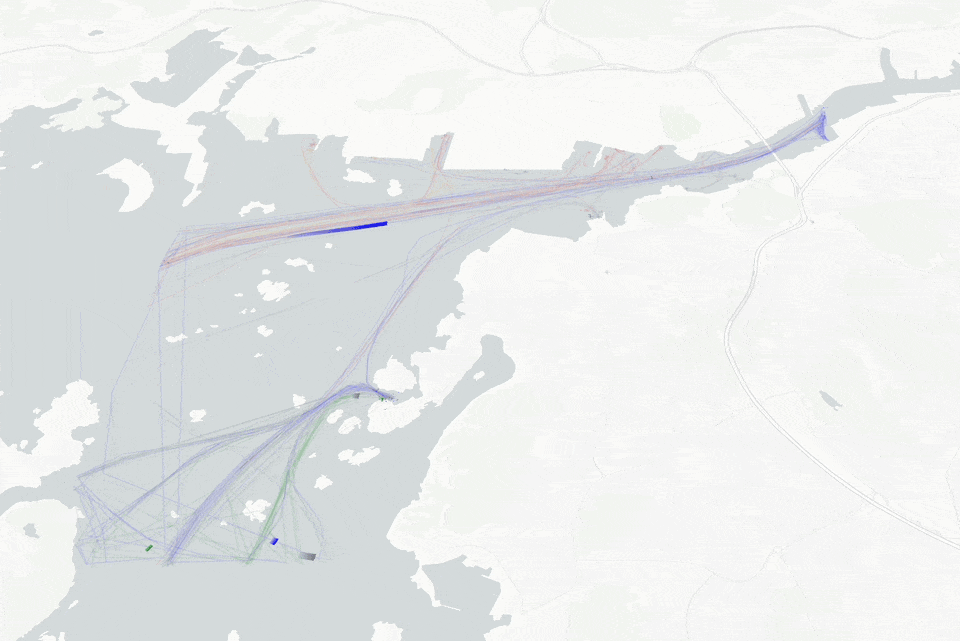

## Dependencies

```
pip install lonboard movingpandas "geopandas>=1" pyarrow
```

## Imports

In [1]:
from datetime import timedelta

import geopandas as gpd
import movingpandas as mpd
import pandas as pd
import pyarrow as pa

from lonboard import Map, PathLayer, viz
from lonboard.colormap import apply_categorical_cmap
from lonboard.experimental import TripsLayer

/Users/kyle/github/developmentseed/lonboard/.venv/lib/python3.11/site-packages/movingpandas/__init__.py:37: UserWarning: Missing optional dependencies. To use the trajectory smoother classes please install Stone Soup (see https://stonesoup.readthedocs.io/en/latest/#installation).
  warnings.warn(e.msg, UserWarning)


## Loading sample AIS data

We'll load the same AIS data as the upstream notebook.


In [2]:
url = "https://raw.githubusercontent.com/movingpandas/movingpandas-examples/refs/heads/main/data/ais.gpkg"
gdf = gpd.read_file(url, use_arrow=True)

Let's see what the data looks like:


In [3]:
gdf.head()

Timestamp       MMSI               NavStatus  SOG    COG  Name  \
0  05/07/2017 00:00:03  219632000  Under way using engine  0.0  270.4  None   
1  05/07/2017 00:00:05  265650970  Under way using engine  0.0    0.5  None   
2  05/07/2017 00:00:06  265503900  Under way using engine  0.0    0.0  None   
3  05/07/2017 00:00:14  219632000  Under way using engine  0.0  188.4  None   
4  05/07/2017 00:00:19  265519650  Under way using engine  0.0  357.2  None   

    ShipType                   geometry  
0  Undefined  POINT (11.85958 57.68817)  
1  Undefined  POINT (11.84175 57.66150)  
2  Undefined  POINT (11.90650 57.69077)  
3  Undefined  POINT (11.85958 57.68817)  
4  Undefined  POINT (11.87192 57.68233)

And let's plot the raw data on a map. This plots each individual point from all ships.


In [4]:
viz(gdf)

Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

As with the upstream example, let's remove any records where the ships aren't moving.


In [5]:
print(f"Original size: {len(gdf)} rows")
gdf = gdf[gdf["SOG"] > 0]
print(f"Reduced to {len(gdf)} rows after removing 0 speed records")

Original size: 84702 rows
Reduced to 33593 rows after removing 0 speed records


## Creating trajectories


This is drawn directly from the upstream example.

In [6]:
gdf["t"] = pd.to_datetime(gdf["Timestamp"], format="%d/%m/%Y %H:%M:%S")
traj_collection = mpd.TrajectoryCollection(gdf, "MMSI", t="t", min_length=100)
print(f"Finished creating {len(traj_collection)} trajectories")

Finished creating 77 trajectories


In [7]:
traj_collection = mpd.MinTimeDeltaGeneralizer(traj_collection).generalize(
    tolerance=timedelta(minutes=1),
)

## Plotting trajectories


In [8]:
shiptype_to_color = {
    "Passenger": "blue",
    "HSC": "green",
    "Tanker": "red",
    "Cargo": "orange",
    "Sailing": "grey",
    "Other": "grey",
    "Tug": "grey",
    "SAR": "grey",
    "Undefined": "grey",
    "Pleasure": "grey",
    "Dredging": "grey",
    "Law enforcement": "grey",
    "Pilot": "grey",
    "Fishing": "grey",
    "Diving": "grey",
    "Spare 2": "grey",
}

We'll extract the ship type from each trajectory. In general, you'd expect this to be consistent, but in this dataset apparently some trajectories have multiple values for this, so we'll take the first unique value.

In [9]:
ship_types = []
for traj in traj_collection.trajectories:
    unique_vals = traj.df["ShipType"].unique()
    # Apparently this is not always consistent
    # assert len(unique_vals) == 1, "Expected single ship type per trajectory"
    ship_types.append(unique_vals[0])

Now we'll use [`apply_categorical_cmap`](https://developmentseed.org/lonboard/latest/api/colormap/#lonboard.colormap.apply_categorical_cmap) to get colors from this data and color mapping.

In [10]:
get_color = apply_categorical_cmap(pa.array(ship_types), shiptype_to_color)

Then we can pass our data to `TripsLayer.from_movingpandas`:

In [11]:
trips_layer = TripsLayer.from_movingpandas(
    traj_collection,
    get_color=get_color,
    width_min_pixels=5,
    trail_length=200,
)

/Users/kyle/github/developmentseed/lonboard/lonboard/experimental/traits.py:146: UserWarning: Reducing precision of input timestamp data to 's' to fit into available GPU precision.
  warnings.warn(


In [12]:
m = Map(trips_layer, _height=600)
m

Map(custom_attribution='', layers=(TripsLayer(get_color=arro3.core.ChunkedArray<FixedSizeList(Field { name: ""…

Now we can animate our data! Click the play button after running the following cell to watch the animation:

In [13]:
trips_layer.animate(step=timedelta(seconds=30), fps=50)

### Adding the full trajectories

We can use the same Arrow data from the above `TripsLayer` and pass that into a `PathLayer`. The Arrow data from the `TripsLayer` is accessed with `trips_layer.table` and can be passed directly into the `table` argument of the `PathLayer`.

We'll set the opacity pretty low as we want the full trajectories to be background information:

In [14]:
linestring_layer = PathLayer(
    table=trips_layer.table,
    get_color=get_color,
    width_min_pixels=1,
    opacity=0.005,
)

And we'll add that layer to the existing map:

In [15]:
m.add_layer(linestring_layer)